# LIBRARIES & PACKAGES

In [ ]:
import pandas as pd
import os
import numpy as np

import matplotlib.pyplot as plt

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate, BatchNormalization

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder

from scipy.signal import find_peaks, spectrogram, stft
from scipy.fft import rfft, rfftfreq


from librosa import zero_crossings
from librosa.display import specshow
from librosa import amplitude_to_db
from xgboost import XGBClassifier

import pickle
import warnings
warnings.filterwarnings("ignore")

ABS_PATH = r"C:\Users\dibmir\OneDrive - Zucchetti S.P.A\Desktop\Università\DSIM"
SAVE_DIR = os.path.join(ABS_PATH, "eeg_test")

# FUNCTIONS

## Features to be extracted

In [ ]:
# Temporal domain features
def peaks_properties(signal_raw):
    peaks, _ = find_peaks(signal_raw)
    num_peaks = np.float64(len(peaks))
    p2p_amplitude = np.ptp(signal_raw)*1.0
    
    return num_peaks, p2p_amplitude

def energy(signal_raw):
    e = np.sum(signal_raw**2)*1.0
    return e

def power(signal_raw):
    pow_ = np.mean(signal_raw**2)*1.0
    return pow_

def zcr(signal_raw):
    zcr_mask = zero_crossings(np.asarray(signal_raw) * 1.0, pad=False)
    zcr_sum = np.sum(zcr_mask)*1.0
    return zcr_sum

def mean_val(signal_raw):
    return np.mean(signal_raw)*1.0

def std_val(signal_raw):
    return np.std(signal_raw)*1.0


# Frequency domain features
def dominant_freq(signal_raw, sampling_rate=173.61):

    fft_result = rfft(signal_raw)
    frequencies = rfftfreq(len(signal_raw), d=1/sampling_rate)
    amplitudes = np.abs(fft_result)
    idx_max = np.argmax(amplitudes)
    dom_freq = frequencies[idx_max]

    return dom_freq, fft_result, frequencies

def feats_spectrogram(signal_raw, rate=173.61):
    f, _, spec = spectrogram(signal_raw, fs=rate)
    mask = f <= 20
    spec_filtered = spec[mask, :]
    return spec_filtered.flatten()
    # return np.array(spec),np.array(spec_filtered), spec_filtered.flatten()

def compute_spectrogram_from_stft(signal_raw, flat=False, filt=False, fs=173.61, nperseg=512, noverlap=64):
    f, t, Zxx = stft(signal_raw, fs=fs, nperseg=nperseg, noverlap=noverlap)
    spec = np.abs(Zxx)
    if filt:
        idx = np.where(f <= 20)[0]
        spec= spec[idx, :]
        # print(spec.shape)
        f = f[idx]
        # t = t[idx]
    if flat:
        return spec.flatten()
    return f,t, spec

# Aggregating function in order to build a descriptor with each single feat extracted value
def handcr_feat_descriptor(signal_raw):
    num_peaks, p2p_amplitude  = peaks_properties(signal_raw)
    e = energy(signal_raw)
    pow_ = power(signal_raw)  
    zcr_ = zcr(signal_raw)
    mean_val_ = mean_val(signal_raw)
    std_val_ = std_val(signal_raw)
    dom_freq_,_,_ = dominant_freq(signal_raw)
    spec_ = compute_spectrogram_from_stft(signal_raw, flat=True, filt=True)
    
    return [num_peaks, p2p_amplitude, 
            e, pow_, zcr_, mean_val_, 
            std_val_, dom_freq_, *spec_]


## Model definition

### Descriptor builder

In [5]:
def concat_lstm_handcr_feat_descriptor(X_train_lstm, X_test_lstm, X_train_handcrafted, X_test_handcrafted):
    
    # Neural network Input inizialization
    inputs_lstm = Input(shape=(X_train_lstm.shape[1], 1)) # shape=(4096,1), where 1 represents
                                                         # 1 feature extracted from each sample

    x_lstm = LSTM(64, return_sequences=True, recurrent_dropout=0.2)(inputs_lstm)
    x_lstm = Dropout(0.2)(x_lstm)

    x_lstm = LSTM(32, return_sequences=False, recurrent_dropout=0.2)(x_lstm)
    x_lstm = Dense(64, activation='relu')(x_lstm)
    x_lstm = Dropout(0.5)(x_lstm)  

    # Input Initialization for Handcrafted Features
    inputs_handcrafted = Input(shape=(X_train_handcrafted.shape[1],)) 

    # Concatenating LSTM-extracted features with handcrafted features
    concatenated = Concatenate()([x_lstm, inputs_handcrafted]) 

    # Model Definition combining LSTM and handcrafted features
    feature_extractor_model = Model(inputs=[inputs_lstm, inputs_handcrafted], 
                                    outputs=concatenated)
    feature_extractor_model.summary()  

    # Reshaping LSTM input data to match model requirements
    X_train_lstm_reshaped = X_train_lstm.values.reshape((X_train_lstm.shape[0],
                                                         X_train_lstm.shape[1], 
                                                         1))


    # Running the model on the training set to extract combined features
    concat_feat_train = feature_extractor_model.predict([X_train_lstm_reshaped, 
                                                        X_train_handcrafted])

    # Reshaping and running the model on the test set
    X_test_lstm_reshaped = X_test_lstm.values.reshape((X_test_lstm.shape[0], 
                                                       X_test_lstm.shape[1],
                                                       1))
    
    concat_feat_test = feature_extractor_model.predict([X_test_lstm_reshaped, 
                                                        X_test_handcrafted])


    return concat_feat_train, concat_feat_test

In [6]:
def load_mod(path: str):
    xgb_model = None
    xgb_model = XGBClassifier()
    xgb_model.load_model(path)
    return xgb_model

### Classifier

In [7]:
def xgb_classifier(X_train, X_test, y_train, lr = None, best_params_pkl_path = None, cols_bt = None, gamma_= None,
                   max_d = None, est = None, reg_a = None, reg_l = None, subs = None):

    
    xgb_model = None
    
    default_params = {
        'objective': 'multi:softmax', 
        'num_class': 5, 
        'use_label_encoder': False, 
        'eval_metric': 'mlogloss'
    }
    
    if isinstance(best_params_pkl_path, str):  # path
        
        try:
            with open(best_params_pkl_path, 'rb') as f:
                best_params = pickle.load(f)
                print("Best parameters loaded from file.")
                xgb_model = XGBClassifier(**best_params.best_params_, **default_params)
        except FileNotFoundError:
                print(f"File '{best_params_pkl_path}' not found. Proceeding with default parameters.")
                xgb_model = XGBClassifier(learning_rate = 0.001, **default_params)
                
    elif best_params_pkl_path is None:
            xgb_model = XGBClassifier(**default_params,learning_rate =lr, colsample_bytree=cols_bt,
                                      gamma=gamma_, max_depth=max_d, n_estimator=est, reg_alpha=reg_a,
                                      reg_lambda=reg_l, subsample=subs)
        
        
    xgb_model.fit(X_train, y_train)
    pred = xgb_model.predict(X_test)
    
    return xgb_model, pred

### Model evaluation

In [8]:
def plot_confusion_matrix(y_true, y_pred):
    
    print("---"*10)
    print("accuracy score: ", round(accuracy_score(y_true, y_pred),2)) # printing the accuracy
    print("---"*10)

    cm = confusion_matrix(y_true, y_pred) # building the confusion matrix

    # Display settings
    y_true_labels = np.unique(y_true)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_true_labels)
    disp.plot(cmap='Blues', values_format='d')

    # Graph settings
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [9]:
def search_for_tuning(X_train, y_train, grid=False, rand=False, early_st=False):
    search = None
    X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, 
                                                            y_train, 
                                                            test_size=0.2, 
                                                            random_state=42)
    # Model config
    if early_st:
        xgb_model = XGBClassifier(
            objective='multi:softmax',
            num_class=5,
            use_label_encoder=False,
            eval_metric='mlogloss',
            early_stopping_rounds=5
        )
        # Preparazione degli eval set per early stopping
        eval_set = [(X_val, y_val)]
        fit_params = {
            "eval_set": eval_set,
            "verbose": False
        }
    else:
        xgb_model = XGBClassifier(
            objective='multi:softmax',
            num_class=5,
            use_label_encoder=False,
            eval_metric='mlogloss'
        )
        fit_params = {}

    # Grid definition
    param_grid = {
        'n_estimators': [100, 300, 500],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.001, 0.1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 0.1, 0.3],
        'reg_alpha': [0, 0.01, 0.1],
        'reg_lambda': [1, 1.5, 2]
    }
    
    if grid:
        search = GridSearchCV(
            estimator=xgb_model,
            param_grid=param_grid,
            scoring='accuracy',
            cv=5,
            verbose=2,
            n_jobs=-1
        )
        search.fit(X_train_sub, y_train_sub, **fit_params)
    
    elif rand:
        search = RandomizedSearchCV(
            estimator=xgb_model,
            param_distributions=param_grid,
            n_iter=50,
            scoring='accuracy',
            cv=10,
            verbose=2,
            n_jobs=-1,
            random_state=42
        )
        search.fit(X_train_sub, y_train_sub, **fit_params)
            
    print("Best Parameters:", search.best_params_)
    print("Best Score:", search.best_score_)
    
    return search

## Data loader & processing

In [10]:
def data_loader(signals: pd.DataFrame, normalize=False):
      
    X = signals.drop(columns=['class']) # dividing signals from classes
    y = signals['class']                # by saving EEG tracings into 'X' variable and
                                    # classes into 'y' variable

    X_handcr_descriptor = X.apply(lambda row: handcr_feat_descriptor(row), axis=1, result_type='expand')
    
    X_train, X_test, y_train, y_test = train_test_split(X_handcr_descriptor, y, test_size=0.1, random_state=42) # train/test splitting
    X_train_lstm = X.iloc[X_train.index]
    X_test_lstm = X.iloc[X_test.index]

    if normalize:
        scaler = StandardScaler() # instantiating 'scaler' object
        scaler.set_output(transform="pandas") # keep a pd.DataFrame as output data structure
        X_train = scaler.fit_transform(X_train, )
        # joblib.dump(scaler, 'scaler.pkl')# scaling data by mean and dividing over std
        X_test = scaler.transform(X_test) # scaling data of the validation set using train set parameters
        
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)  # Converting ['A','B','C','D','E'] labels in [0,1,2,3,4]
    y_test = le.transform(y_test)

    return X_train, X_test, y_train, y_test, X_train_lstm, X_test_lstm


# MAIN

## Data reading & loading

In [11]:
file_path = os.path.join(ABS_PATH, "eeg.csv")
eeg = pd.read_csv(file_path, sep=";")
eeg_no_cl = eeg.drop(columns=['class'])
eeg_no_cl.shape

(500, 4097)

In [12]:
X_train, X_test, y_train, y_test, X_train_lstm, X_test_lstm = data_loader(eeg, normalize=True)

In [13]:
# Extracting features and descriptor building
extracted_features_train, extracted_features_test = concat_lstm_handcr_feat_descriptor(
                                                                                        X_train_lstm=X_train_lstm,
                                                                                        X_test_lstm=X_test_lstm,
                                                                                        X_train_handcrafted=X_train,
                                                                                        X_test_handcrafted=X_test)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4097, 1)]    0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 4097, 64)     16896       ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4097, 64)     0           ['lstm[0][0]']                   
                                                                                                  
 lstm_1 (LSTM)                  (None, 32)           12416       ['dropout[0][0]']                
                                                                                              

* lstm_1 has an output shape of  (None, 64) with 2 dimensions (but 1) due to "return_sequence=False" which is equal to flatten()

#### Plot spectr with STFT

In [40]:
import librosa
def plot_spec(y,frame_size, hop_length,y_axis='log'):
    plt.figure(figsize=(25,10))
    specshow(np.abs(librosa.stft(y*1.0)),
             sr=frame_size,
             hop_length=hop_length,
             x_axis='time',
             y_axis=y_axis)
    plt.colorbar(format="%+2.f")

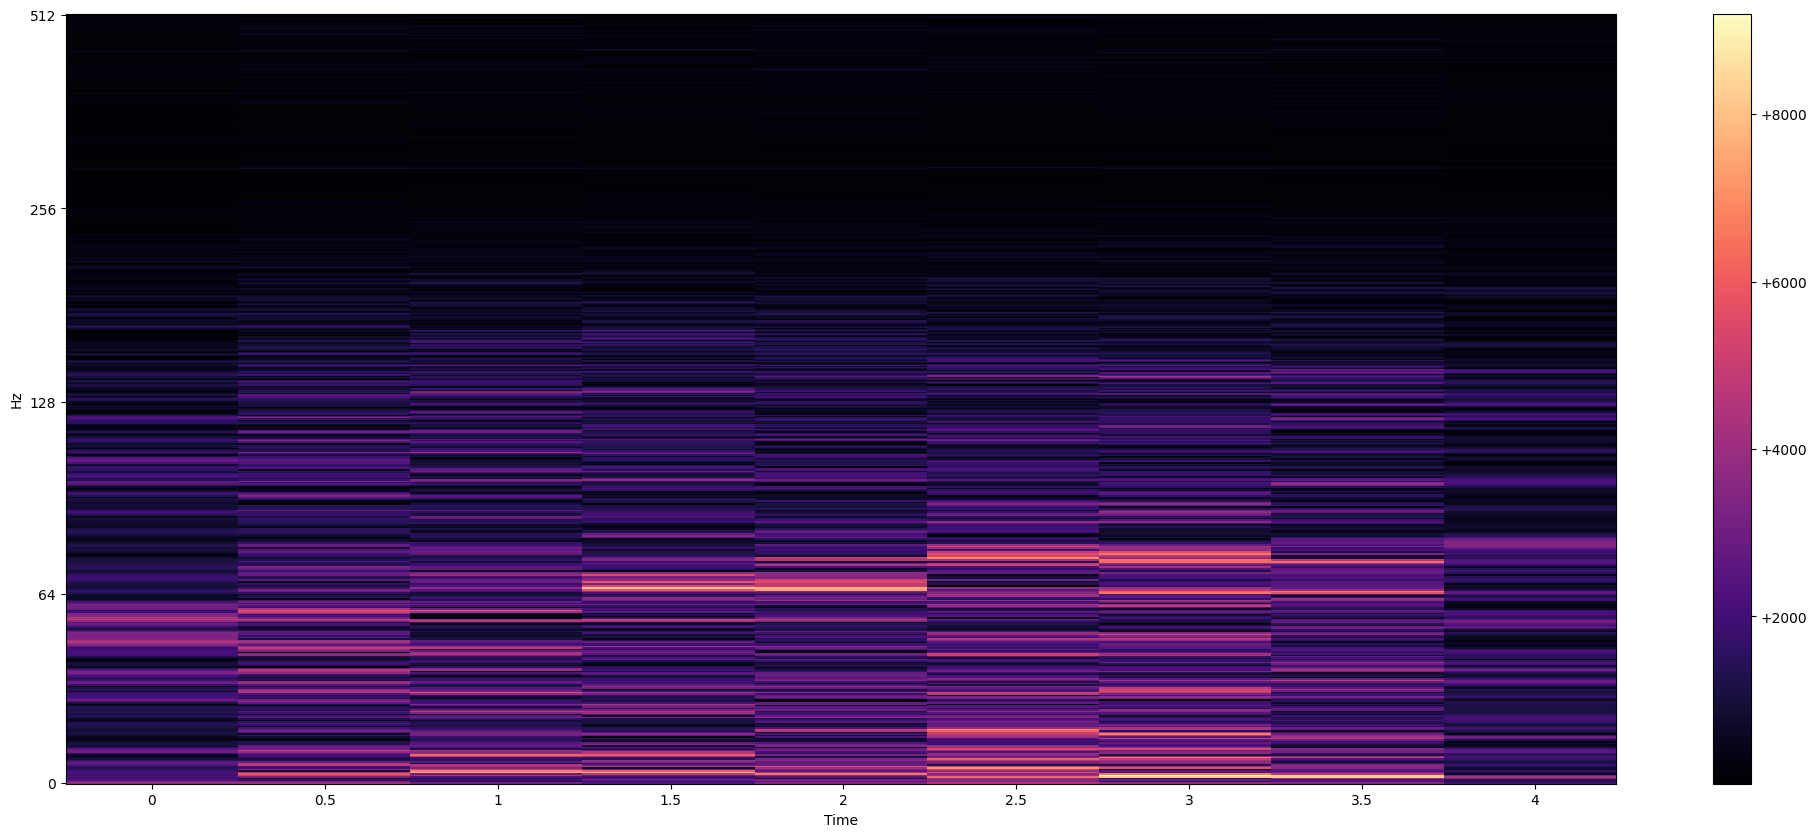

In [41]:
plot_spec(eeg_no_cl.iloc[1].to_numpy(), frame_size=1028, hop_length=512)

(59, 11)


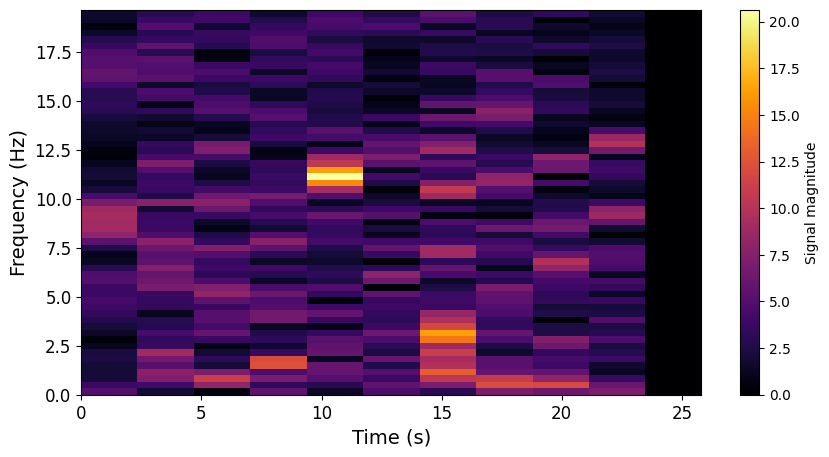

In [16]:
spec_freqs, spec_times,spec = compute_spectrogram_from_stft(eeg_no_cl.iloc[1], filt=True, flat=False)
print(spec.shape)

# Plot dello spettrogramma
plt.figure(figsize=(10, 5))
plt.imshow(spec, 
           extent=[spec_times[0], spec_times[-1], spec_freqs[0], spec_freqs[-1]],  # Usa spec.shape per dimensioni
           origin='lower', aspect='auto', interpolation='nearest', cmap='inferno')

plt.colorbar(label="Signal magnitude")
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Frequency (Hz)", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# plt.title("Spectrogram from STFT")
plt.show()

#### Plot FFT

In [13]:
np.random.seed(42)
random_idx = [np.random.randint(0, 500) for _ in range(5)]
print(random_idx)

[102, 435, 348, 270, 106]


In [14]:
_,fft_0, freqs_0 = dominant_freq(eeg_no_cl.iloc[random_idx[0]])
_,fft_1, freqs_1 = dominant_freq(eeg_no_cl.iloc[random_idx[1]])
_,fft_2, freqs_2 = dominant_freq(eeg_no_cl.iloc[random_idx[2]])

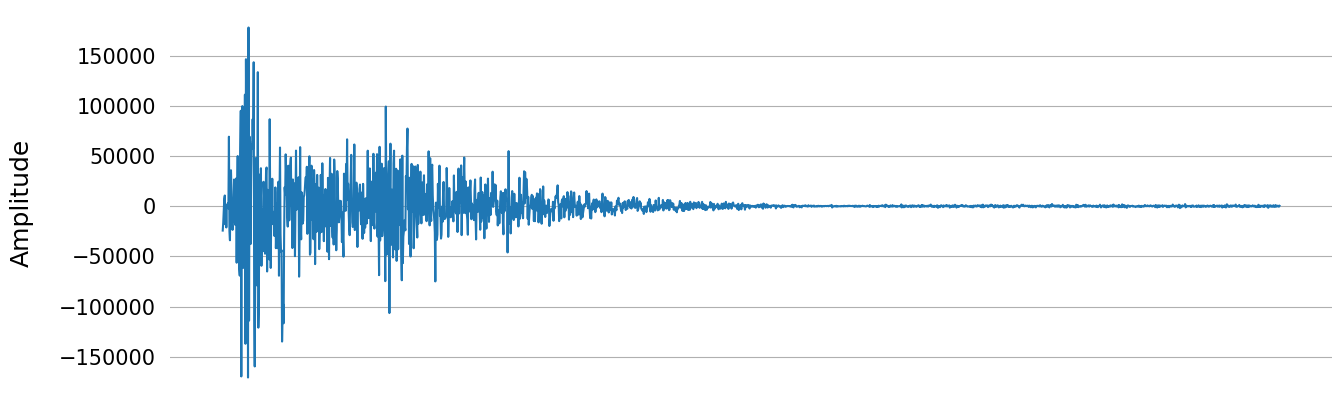

In [15]:
plt.figure(figsize=(15, 5))
plt.plot(freqs_1, fft_1)
# plt.title('FFT')
# plt.xlabel('Frequency (Hz)', fontsize=18, labelpad=20)
plt.ylabel('Amplitude', fontsize=18, labelpad=18)
plt.tick_params(axis='x', length=0)
plt.tick_params(axis='y', length=0)


for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.grid(True, axis='y')

# plt.axvline(x=20, color='r', linestyle='--', label='x = 20')
# plt.xticks([20], ['20'], fontsize=15)
# plt.xticks(fontsize=15)
plt.xticks([])
plt.yticks(fontsize=15)
ax = plt.gca()

ax.tick_params(axis='x', pad=15)  
ax.tick_params(axis='y', pad=10)

plt.show()

# MODEL RUNNING

In [16]:
bp_path = r'C:\Users\dibmir\OneDrive - Zucchetti S.P.A\Desktop\Università\DSIM\hyperparam tuning\gs_xgb.pkl'
mod, prdct = xgb_classifier(X_train=extracted_features_train,
                       X_test=extracted_features_test,
                       y_train=y_train,
                       best_params_pkl_path=bp_path)

Best parameters loaded from file.


              precision    recall  f1-score   support

           0       1.00      0.87      0.93        15
           1       0.78      1.00      0.88         7
           2       0.75      1.00      0.86         3
           3       1.00      0.83      0.91        12
           4       0.93      1.00      0.96        13

    accuracy                           0.92        50
   macro avg       0.89      0.94      0.91        50
weighted avg       0.94      0.92      0.92        50

------------------------------
accuracy score:  0.92
------------------------------


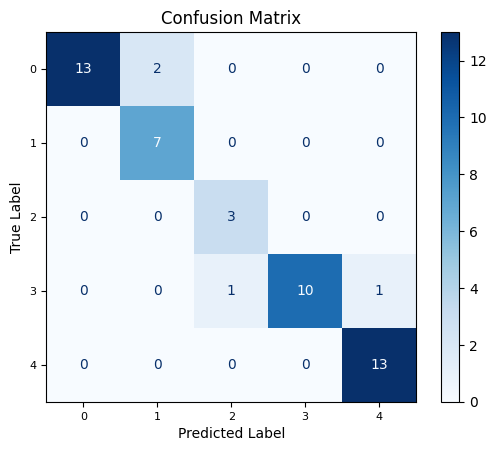

In [17]:
print(classification_report(y_test, prdct))
plot_confusion_matrix(y_true=y_test, y_pred=prdct)

              precision    recall  f1-score   support

           0       1.00      0.87      0.93        15
           1       0.78      1.00      0.88         7
           2       0.75      1.00      0.86         3
           3       1.00      0.92      0.96        12
           4       1.00      1.00      1.00        13

    accuracy                           0.94        50
   macro avg       0.91      0.96      0.92        50
weighted avg       0.95      0.94      0.94        50

------------------------------
accuracy score:  0.94
------------------------------


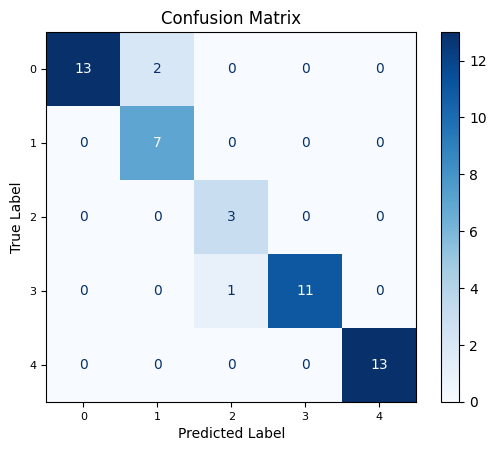

In [18]:
# mod.save_model('best_model_94.model')
mod = load_mod(r'C:\Users\dibmir\OneDrive - Zucchetti S.P.A\Desktop\Università\DSIM\src\best_model_94.model')
predictions = mod.predict(extracted_features_test)
print(classification_report(y_test, predictions))
plot_confusion_matrix(y_true=y_test, y_pred=predictions)

## Considerations

* if varying the value of freq filter, it could be noticed that:
    * at a low level (i.e. 5 or 10), the performance is worst -> 0.8
    * at a high level, such as the whole flatten spectrogram, the performance does not increase than that obtained with freq_limit = 20 -> 0.86<br>

* the actual information gain seems to be provided by spectrogram component, since an accuracy score of 0.68 is obtain is they are excluded from the set of features. On the other hand, if neural feature are dropped, the accuracy score is 0.8, demonstrating that they lead to a pretty little short improvement on training

* VERY IMPORTANT: after playing around on changing 'nperseg' and 'overlap' params of stft, the best extraction results of making larger Frequency feats extraction (by increasing the rate of 'nperseg') and shortening di overlapping rate so that i avoid the analysis on time -> accuracy = 0.94


## HANDCRAFTED FEATURES ONLY

In [19]:
bp_hc_only_bp_path = r'C:\Users\dibmir\OneDrive - Zucchetti S.P.A\Desktop\Università\DSIM\hyperparam tuning\gs_xgb.pkl'
pred_handcr_only = xgb_classifier(X_train=X_train,
                       X_test=X_test,
                       y_train=y_train,
                       best_params_pkl_path=bp_hc_only_bp_path)

Best parameters loaded from file.


------------------------------
accuracy score:  0.9
------------------------------


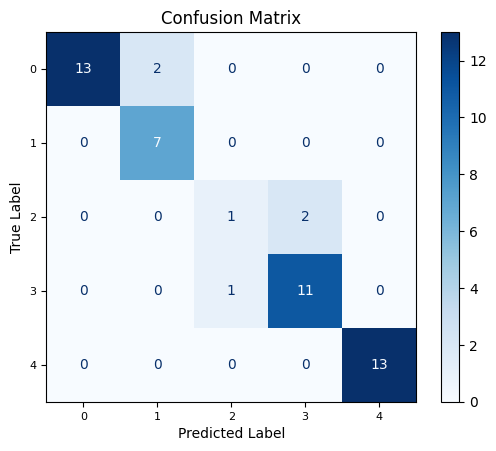

In [20]:
plot_confusion_matrix(y_test, pred_handcr_only)

## TUNING

### Search

In [ ]:
search_result = search_for_tuning(X_train=extracted_features_train, 
                                  y_train=y_train,
                                  grid=True,
                                  early_st=True)

### Write the best params

In [ ]:
# with open('rs_2_lay_lstm_xgn.pkl', 'wb') as f:
#     pickle.dump(random_search, f)

### Load the best params

In [22]:
# with open(r'C:\Users\dibmir\OneDrive - Zucchetti S.P.A\Desktop\Università\DSIM\hyperparam tuning\gs_xgb.pkl', 'rb') as f:
#     gs_loaded = pickle.load(f)
# print(gs_loaded.best_params_)